# General imports

In [1]:
import os,sys, glob,shutil
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tif
#matplotlib inline

In [2]:
# this line is so the modules in the next cell get imported. They live in this path.
# Change this to where you cloned ClearMap2
sys.path.append('/home/emilyjanedennis/Desktop/GitHub/rat_BrainPipe/ClearMap2')

## Clearmap specific imports

In [3]:
import ClearMap.IO.Workspace as wsp
import ClearMap.IO.IO as io
import ClearMap.ImageProcessing.Experts.Cells as cells

/home/emilyjanedennis/anaconda3/envs/cm2/lib/python3.6/site-packages/vispy/visuals/line/line.py:395: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ('color', np.float32, 4)])
/home/emilyjanedennis/anaconda3/envs/cm2/lib/python3.6/site-packages/vispy/visuals/line/arrow.py:57: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ('linewidth', np.float32, 1)
/home/emilyjanedennis/anaconda3/envs/cm2/lib/python3.6/site-packages/vispy/visuals/isocurve.py:22: UserWarning: VisPy is not yet compatible with matplotlib 2.2+
  warnings.warn("VisPy is not yet compatible with matplotlib 2.2+")


# Set up the workspace


In [7]:
directory = os.path.join('/home/emilyjanedennis/scratch/cm2_brains/j316/ch_488')

ws = wsp.Workspace('CellMap', directory=directory);
ws.info()

Workspace[CellMap]{/home/emilyjanedennis/scratch/cm2_brains/j316/ch_488}
              raw: no file
 autofluorescence: no file
         stitched: stitched.npy
           layout: no file
       background: no file
        resampled: no file
resampled_to_auto: no file
auto_to_reference: no file
            cells: no file
          density: no file



In [8]:

expression_raw      = 'renamed/Z<Z,4>.tif'    
ws.update(raw=expression_raw)
ws.update(stitched='stitched.npy')
ws.info()

Workspace[CellMap]{/home/emilyjanedennis/scratch/cm2_brains/j316/ch_488}
              raw: renamed/Z<Z,4>.tif {3880 files, ('Z',): (0,) -> (3879,)}
 autofluorescence: no file
         stitched: stitched.npy
           layout: no file
       background: no file
        resampled: no file
resampled_to_auto: no file
auto_to_reference: no file
            cells: no file
          density: no file



## Make a small subvolume slice to test the cell detection on


j316:
5000,6000 in x,y z=30000 (1500) posterior right visual
4300,5300 x y = 800,1800, z=20000 (1000)anterior right frontal/motor


In [159]:
ws.debug = 'testchunk' 
slicing = (slice(2200,2500),slice(1000,2400),slice(975,1000))
ws.create_debug('stitched', slicing=slicing) # creates a file called testchunk_stitched

'/home/emilyjanedennis/scratch/cm2_brains/j316/ch_488/testchunk_stitched.npy'

(300, 1400)


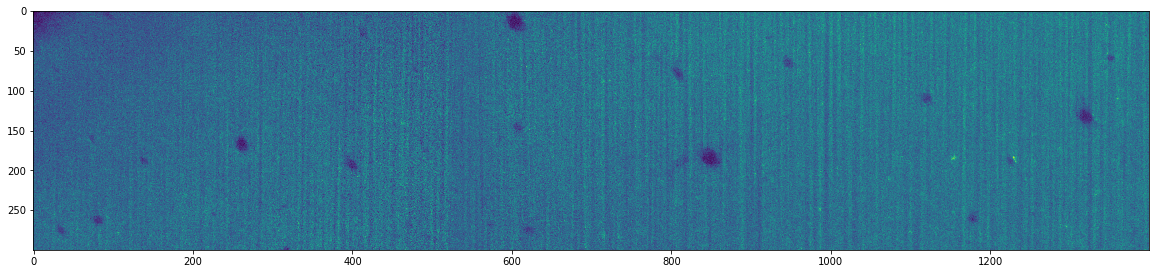

In [160]:
# visually validate that this chunk has tissue and some cells in it
z_plane_to_look_at = 0 # this is z plane of the subvolume we want to look at. Change it to look at other z planes.
stitched_z_plane = ws.source('stitched')[:,:,z_plane_to_look_at] 
print(stitched_z_plane.shape)

fig = plt.figure(figsize=(20,20))
ax=fig.add_subplot(111)
ax.imshow(stitched_z_plane)

# Run the cell detection on this test volume
Just using some initial parameters to make sure we have everything set up properly.

With a subvolume with shape: 500,500,30 the cell detection should only take a few seconds


In [161]:
cell_detection_parameter = cells.default_cell_detection_parameter.copy()
cell_detection_parameter['illumination'] = None
cell_detection_parameter['background_correction']['shape'] = (7,7)
cell_detection_parameter['intensity_detection']['measure'] = ['source','background']
cell_detection_parameter['shape_detection']['threshold'] = 220

io.delete_file(ws.filename('cells', postfix='maxima'))
cell_detection_parameter['maxima_detection']['save'] = ws.filename('cells', postfix='maxima')

processing_parameter = cells.default_cell_detection_processing_parameter.copy()
processing_parameter.update(
    processes = 'serial',
    size_max = 100, #35,
    size_min = 30, #30,
    overlap  = 15, #10,
    verbose = True
    )


In [ ]:

cells.detect_cells(ws.filename('stitched'), ws.filename('cells', postfix='raw'),
                   cell_detection_parameter=cell_detection_parameter,
                   processing_parameter=processing_parameter)

This should have saved a file called testchunk_cells_raw.npy in your output directory that you set at the beginning.

## Show cells overlaid on top of tissue to validate cell detection

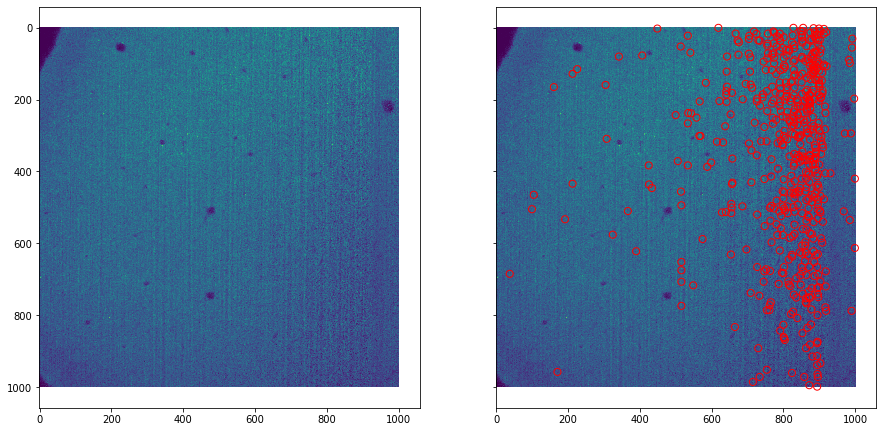

In [121]:
coordinates = np.hstack([ws.source('cells', postfix='raw')[c][:,None] for c in 'xyz']);
this_plane_coords = np.array([coord for coord in coordinates if coord[-1] ==0])
xs = this_plane_coords[:,0]
ys = this_plane_coords[:,1]
fig,axes = plt.subplots(figsize=(15,8),nrows=1,ncols=2,sharex=True,sharey=True)
ax_tissue = axes[0]
ax_tissue.imshow(stitched_z_plane,cmap='viridis')
ax_both=axes[1]
ax_both.imshow(stitched_z_plane,cmap='viridis')
ax_both.scatter(ys,xs,s=50,facecolors='none',edgecolors='r')

## Run the "parameter sweep" 
This runs a loop over a bunch of parameters and saves out a .npy file for each parameter set 

In [162]:
# Here are the parameters we used above:
cell_detection_parameter

{'iullumination_correction': {'flatfield': None, 'scaling': 'mean'},
 'background_correction': {'shape': (7, 7), 'form': 'Disk', 'save': False},
 'equalization': None,
 'dog_filter': {'shape': None, 'sigma': None, 'sigma2': None},
 'maxima_detection': {'h_max': None,
  'shape': 5,
  'threshold': 0,
  'valid': True,
  'save': '/home/emilyjanedennis/scratch/cm2_brains/j316/ch_488/testchunk_cells_maxima.npy'},
 'shape_detection': {'threshold': 220, 'save': False},
 'intensity_detection': {'method': 'max',
  'shape': 3,
  'measure': ['source', 'background']},
 'illumination': None}

In [163]:
# Here we list the parameter ranges to sweep over.
background_sizes = [7,9] # will make xy tuples like: (5,5), (7,7), (9,9)  
shape_threshold_sizes = [220,250]

In [164]:
from itertools import product
for background_size,shape_threshold_size in product(background_sizes,shape_threshold_sizes):
    this_cell_parameter_dict = cell_detection_parameter.copy()
    this_cell_parameter_dict['background_correction']['shape'] = (background_size,background_size)
    this_cell_parameter_dict['shape_detection']['threshold'] = shape_threshold_size
    postfix = f'raw_bck{background_size}_shpthresh{shape_threshold_size}'
#     print(ws.filename('cells', postfix=postfix))
    cells.detect_cells(ws.filename('stitched'), ws.filename('cells', postfix=postfix),
        cell_detection_parameter=this_cell_parameter_dict,
        processing_parameter=processing_parameter)

Processing 1 blocks with function 'detect_cells_block'.
Processing block 0/1<(0, 0, 0)/(1, 1, 1)> (300, 1400, 25)@(300, 1400, 25)[(:,:,0:25)]
Block 0/1<(0, 0, 0)/(1, 1, 1)> (300, 1400, 25)@(300, 1400, 25)[(:,:,0:25)]: Background removal shape: (7, 7)
Block 0/1<(0, 0, 0)/(1, 1, 1)> (300, 1400, 25)@(300, 1400, 25)[(:,:,0:25)]: Background removal form : Disk
Block 0/1<(0, 0, 0)/(1, 1, 1)> (300, 1400, 25)@(300, 1400, 25)[(:,:,0:25)]: Background removal save : False
Block 0/1<(0, 0, 0)/(1, 1, 1)> (300, 1400, 25)@(300, 1400, 25)[(:,:,0:25)]: Illumination correction: elapsed time: 0:00:00.167
Block 0/1<(0, 0, 0)/(1, 1, 1)> (300, 1400, 25)@(300, 1400, 25)[(:,:,0:25)]: DoG filter: shape : None
Block 0/1<(0, 0, 0)/(1, 1, 1)> (300, 1400, 25)@(300, 1400, 25)[(:,:,0:25)]: DoG filter: sigma : None
Block 0/1<(0, 0, 0)/(1, 1, 1)> (300, 1400, 25)@(300, 1400, 25)[(:,:,0:25)]: DoG filter: sigma2: None
Block 0/1<(0, 0, 0)/(1, 1, 1)> (300, 1400, 25)@(300, 1400, 25)[(:,:,0:25)]: DoG filter: elapsed time: 0:

Block 0/1<(0, 0, 0)/(1, 1, 1)> (300, 1400, 25)@(300, 1400, 25)[(:,:,0:25)]: Shape detection: elapsed time: 0:00:00.845
Block 0/1<(0, 0, 0)/(1, 1, 1)> (300, 1400, 25)@(300, 1400, 25)[(:,:,0:25)]: Cell detection: elapsed time: 0:01:40.275
Processing block 0/1<(0, 0, 0)/(1, 1, 1)> (300, 1400, 25)@(300, 1400, 25)[(:,:,0:25)]: elapsed time: 0:01:40.425
Processed 1 blocks with function 'detect_cells_block': elapsed time: 0:01:40.564
Processing 1 blocks with function 'detect_cells_block'.
Processing block 0/1<(0, 0, 0)/(1, 1, 1)> (300, 1400, 25)@(300, 1400, 25)[(:,:,0:25)]
Block 0/1<(0, 0, 0)/(1, 1, 1)> (300, 1400, 25)@(300, 1400, 25)[(:,:,0:25)]: Background removal shape: (9, 9)
Block 0/1<(0, 0, 0)/(1, 1, 1)> (300, 1400, 25)@(300, 1400, 25)[(:,:,0:25)]: Background removal form : Disk
Block 0/1<(0, 0, 0)/(1, 1, 1)> (300, 1400, 25)@(300, 1400, 25)[(:,:,0:25)]: Background removal save : False
Block 0/1<(0, 0, 0)/(1, 1, 1)> (300, 1400, 25)@(300, 1400, 25)[(:,:,0:25)]: Illumination correction: el

## Visualize the different results from the parameter sweep

# Background shape size: 7, shape threshold size: 220 
Detected 6970 total cells


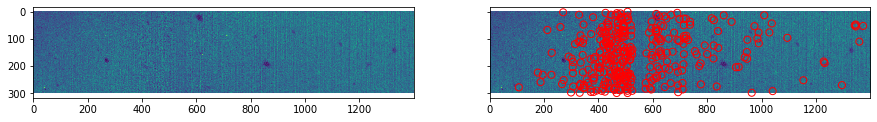

# Background shape size: 7, shape threshold size: 250 
Detected 1754 total cells


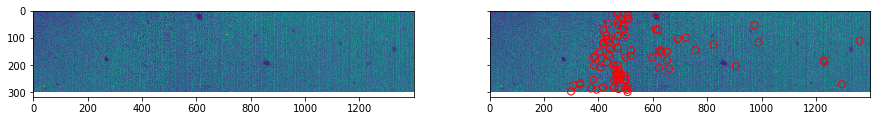

# Background shape size: 9, shape threshold size: 220 
Detected 10201 total cells


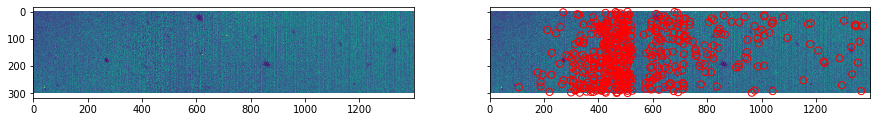

# Background shape size: 9, shape threshold size: 250 
Detected 2813 total cells


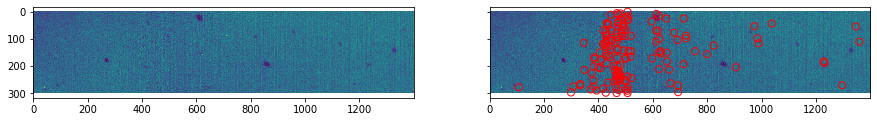

In [165]:
z_plane_to_look_at = 20 
stitched_z_plane = ws.source('stitched')[:,:,z_plane_to_look_at] 

for background_size,shape_threshold_size in product(background_sizes,shape_threshold_sizes):
    postfix = f'raw_bck{background_size}_shpthresh{shape_threshold_size}'
    print(f"# Background shape size: {background_size}, shape threshold size: {shape_threshold_size} ")

    source = ws.source('cells', postfix=postfix)
    n_tot = len(source['x'])
    print(f"Detected {n_tot} total cells")
    coordinates = np.hstack([source[c][:,None] for c in 'xyz']);
    this_plane_coords = np.array([coord for coord in coordinates if coord[-1] ==0])
    xs = this_plane_coords[:,0]
    ys = this_plane_coords[:,1]
    fig,axes = plt.subplots(figsize=(15,8),nrows=1,ncols=2,sharex=True,sharey=True)
    ax_tissue = axes[0]
    ax_tissue.imshow(stitched_z_plane,cmap='viridis')
    ax_both=axes[1]
    ax_both.imshow(stitched_z_plane,cmap='viridis')
    ax_both.scatter(ys,xs,s=50,facecolors='none',edgecolors='r')
    plt.show()

In [167]:
background_size_opt = 7
shape_threshold_size_opt = 220
this_cell_parameter_dict = cell_detection_parameter.copy()
this_cell_parameter_dict['background_correction']['shape'] = (background_size_opt,background_size_opt)
this_cell_parameter_dict['shape_detection']['threshold'] = shape_threshold_size_opt
postfix = f'raw_bck{background_size_opt}_shpthresh{shape_threshold_size_opt}'
cells.detect_cells(ws.filename('stitched'), ws.filename('cells', postfix=postfix),
    cell_detection_parameter=this_cell_parameter_dict,
    processing_parameter=processing_parameter)

Processing 1 blocks with function 'detect_cells_block'.
Processing block 0/1<(0, 0, 0)/(1, 1, 1)> (300, 300, 20)@(300, 300, 20)[(:,:,0:20)]
Block 0/1<(0, 0, 0)/(1, 1, 1)> (300, 300, 20)@(300, 300, 20)[(:,:,0:20)]: Background removal shape: (7, 7)
Block 0/1<(0, 0, 0)/(1, 1, 1)> (300, 300, 20)@(300, 300, 20)[(:,:,0:20)]: Background removal form : Disk
Block 0/1<(0, 0, 0)/(1, 1, 1)> (300, 300, 20)@(300, 300, 20)[(:,:,0:20)]: Background removal save : False
Block 0/1<(0, 0, 0)/(1, 1, 1)> (300, 300, 20)@(300, 300, 20)[(:,:,0:20)]: Illumination correction: elapsed time: 0:00:00.041
Block 0/1<(0, 0, 0)/(1, 1, 1)> (300, 300, 20)@(300, 300, 20)[(:,:,0:20)]: DoG filter: shape : None
Block 0/1<(0, 0, 0)/(1, 1, 1)> (300, 300, 20)@(300, 300, 20)[(:,:,0:20)]: DoG filter: sigma : None
Block 0/1<(0, 0, 0)/(1, 1, 1)> (300, 300, 20)@(300, 300, 20)[(:,:,0:20)]: DoG filter: sigma2: None
Block 0/1<(0, 0, 0)/(1, 1, 1)> (300, 300, 20)@(300, 300, 20)[(:,:,0:20)]: DoG filter: elapsed time: 0:00:00.000
Block 0/

'/home/emilyjanedennis/scratch/cm2_brains/j316/ch_642/testchunk_cells_raw_bck7_shpthresh220.npy'

In [168]:
# Now visualize

Z=0 plane


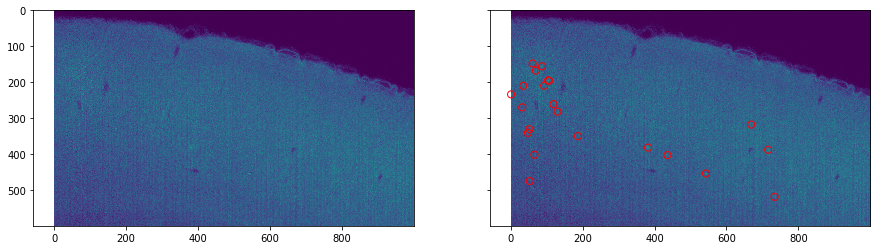

Z=1 plane


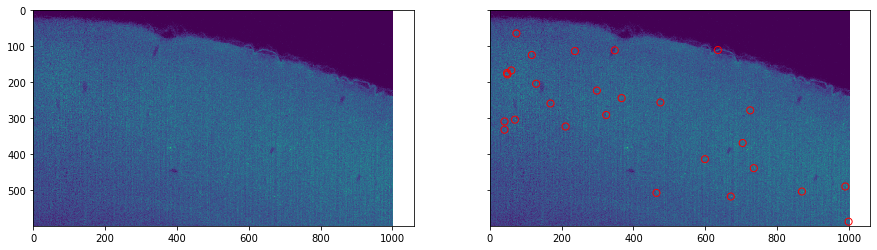

Z=2 plane


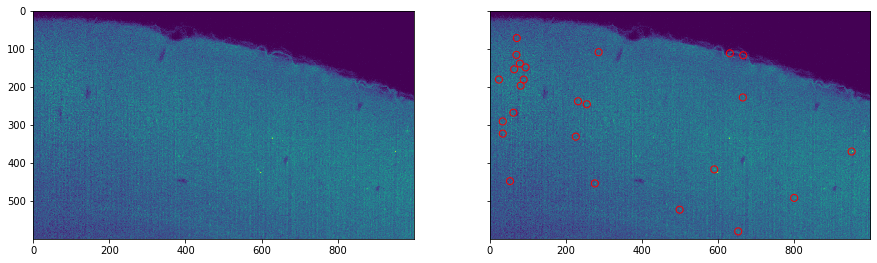

Z=3 plane


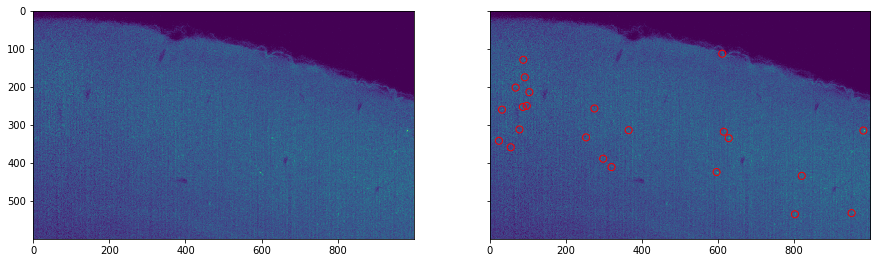

Z=4 plane


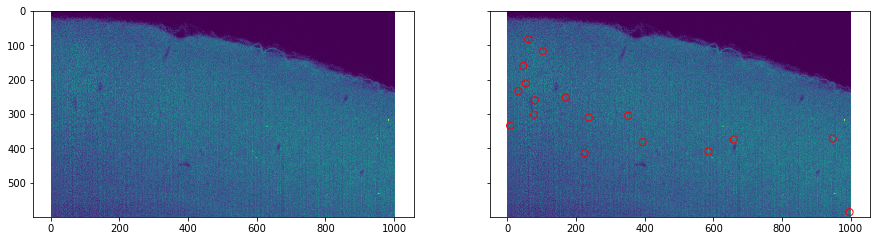

Z=5 plane


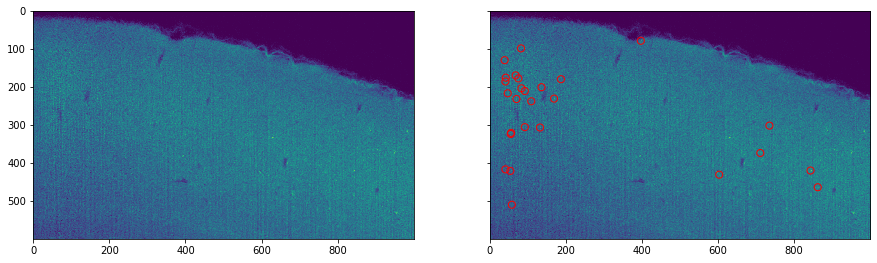

Z=6 plane


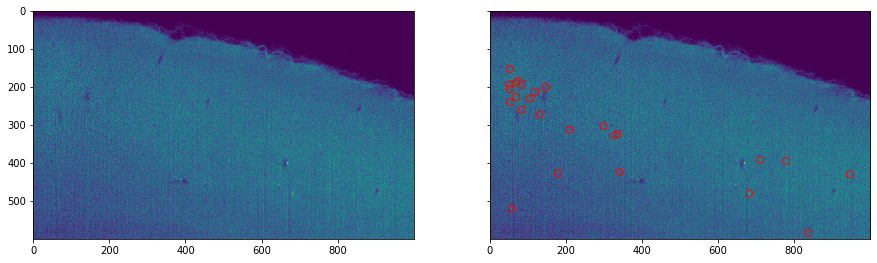

Z=7 plane


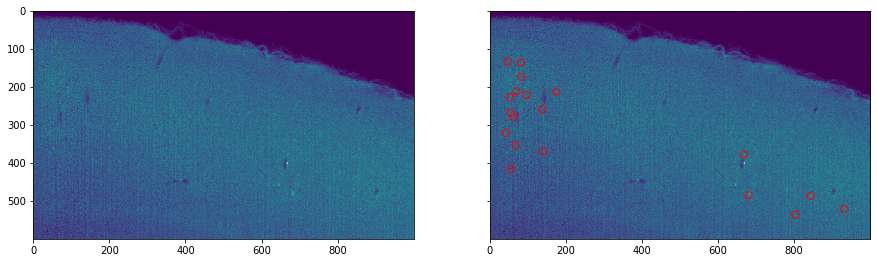

Z=8 plane


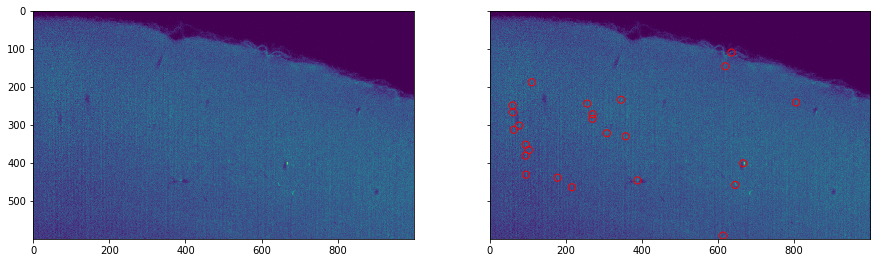

Z=9 plane


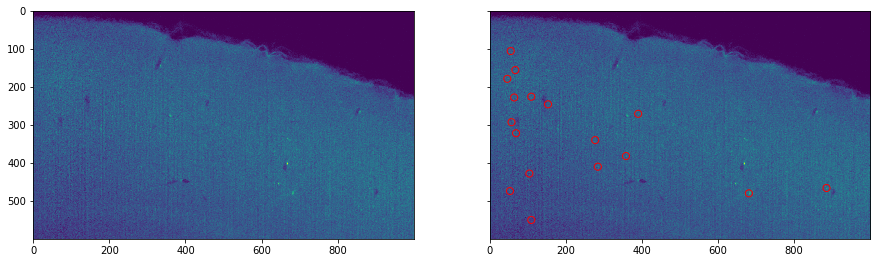

In [71]:
# Now let's look at every 5th plane
postfix = f'raw_bck{5}_shpthresh{250}'
source = ws.source('cells', postfix=postfix)
coordinates = np.hstack([source[c][:,None] for c in 'xyz']);
for z in range(0,10,1):
    print(f"Z={z} plane")
    stitched_z_plane = ws.source('stitched')[:,:,z]
    this_plane_coords = np.array([coord for coord in coordinates if coord[-1] == z])
    xs = this_plane_coords[:,0]
    ys = this_plane_coords[:,1]
    fig,axes = plt.subplots(figsize=(15,8),nrows=1,ncols=2,sharex=True,sharey=True)
    ax_tissue = axes[0]
    
    ax_tissue.imshow(stitched_z_plane,cmap='viridis')
    ax_both=axes[1]
    ax_both.imshow(stitched_z_plane,cmap='viridis')
    ax_both.scatter(ys,xs,s=50,facecolors='none',edgecolors='r')
    plt.show()

# Use these cell detection parameters on a new subvolume of the brain
This is to make sure these cell detection parameters are generally appropriate throughout the brain, not just in this small subchunk we happened to choose. We want to do this before we run the cell detection on the entire brain using these parameters

In [119]:
# First let's find a section of the brain with tissue in it that is the same shape as our original test chunk

In [151]:
ws.debug = 'validatechunk' 
slicing = (slice(3000,3500),slice(2500,3000),slice(2000,2050))
ws.create_debug('stitched', slicing=slicing) # creates a file called validatechunk_stitched.npy

'/home/emilyjanedennis/scratch/cm2_brains/j317/ch_642/validatechunk_stitched.npy'

In [152]:

cell_detection_parameter = cells.default_cell_detection_parameter.copy()
cell_detection_parameter['illumination'] = None
cell_detection_parameter['intensity_detection']['measure'] = ['source','background']
this_cell_parameter_dict = cell_detection_parameter.copy()
this_cell_parameter_dict['maxima_detection']['save'] = False
this_cell_parameter_dict['background_correction']['shape'] = (background_size_opt,background_size_opt)
this_cell_parameter_dict['shape_detection']['threshold'] = shape_threshold_size_opt
processing_parameter = cells.default_cell_detection_processing_parameter.copy()
processing_parameter.update(
    processes = 'serial',
    size_max = 100, #35,
    size_min = 30, #30,
    overlap  = 15, #10,
    verbose = True
    )
postfix = f'raw_bck{background_size_opt}_shpthresh{shape_threshold_size_opt}'
#     print(ws.filename('cells', postfix=postfix))
cells.detect_cells(ws.filename('stitched'), ws.filename('cells', postfix=postfix),
    cell_detection_parameter=this_cell_parameter_dict,
    processing_parameter=processing_parameter)

Processing 1 blocks with function 'detect_cells_block'.
Processing block 0/1<(0, 0, 0)/(1, 1, 1)> (500, 500, 50)@(500, 500, 50)[(:,:,0:50)]
Block 0/1<(0, 0, 0)/(1, 1, 1)> (500, 500, 50)@(500, 500, 50)[(:,:,0:50)]: Background removal shape: (5, 5)
Block 0/1<(0, 0, 0)/(1, 1, 1)> (500, 500, 50)@(500, 500, 50)[(:,:,0:50)]: Background removal form : Disk
Block 0/1<(0, 0, 0)/(1, 1, 1)> (500, 500, 50)@(500, 500, 50)[(:,:,0:50)]: Background removal save : False
Block 0/1<(0, 0, 0)/(1, 1, 1)> (500, 500, 50)@(500, 500, 50)[(:,:,0:50)]: Illumination correction: elapsed time: 0:00:00.146
Block 0/1<(0, 0, 0)/(1, 1, 1)> (500, 500, 50)@(500, 500, 50)[(:,:,0:50)]: DoG filter: shape : None
Block 0/1<(0, 0, 0)/(1, 1, 1)> (500, 500, 50)@(500, 500, 50)[(:,:,0:50)]: DoG filter: sigma : None
Block 0/1<(0, 0, 0)/(1, 1, 1)> (500, 500, 50)@(500, 500, 50)[(:,:,0:50)]: DoG filter: sigma2: None
Block 0/1<(0, 0, 0)/(1, 1, 1)> (500, 500, 50)@(500, 500, 50)[(:,:,0:50)]: DoG filter: elapsed time: 0:00:00.000
Block 0/

'/home/emilyjanedennis/scratch/cm2_brains/j317/ch_642/validatechunk_cells_raw_bck5_shpthresh220.npy'

Z=1 plane


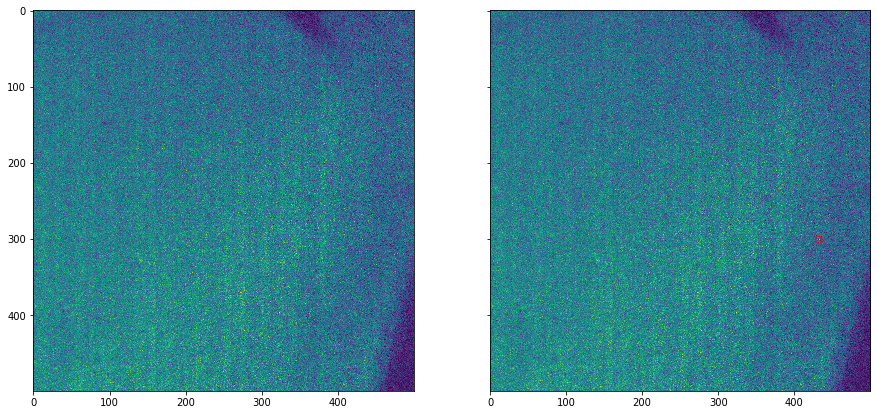

Z=2 plane


IndexError: too many indices for array

In [154]:
# Now let's look at every 5th plane for this new validation chunk as we did for the test chunk
postfix = f'raw_bck{background_size_opt}_shpthresh{shape_threshold_size_opt}'

source = ws.source('cells', postfix=postfix)
coordinates = np.hstack([source[c][:,None] for c in 'xyz']);
for z in range(1,4,1):
    print(f"Z={z} plane")
    stitched_z_plane = ws.source('stitched')[:,:,z]
    this_plane_coords = np.array([coord for coord in coordinates if coord[-1] == z])
    xs = this_plane_coords[:,0]
    ys = this_plane_coords[:,1]
    fig,axes = plt.subplots(figsize=(15,8),nrows=1,ncols=2,sharex=True,sharey=True)
    ax_tissue = axes[0]
    ax_tissue.imshow(stitched_z_plane,cmap='viridis')
    ax_both=axes[1]
    ax_both.imshow(stitched_z_plane,cmap='viridis')
    ax_both.scatter(ys,xs,s=50,facecolors='none',edgecolors='r')
    plt.show()

In [ ]:
# Looks pretty good! Let's use these parameters to run on the entire brain.

In [5]:
ws.debug = 'testchunk-script' 


Z=0 plane


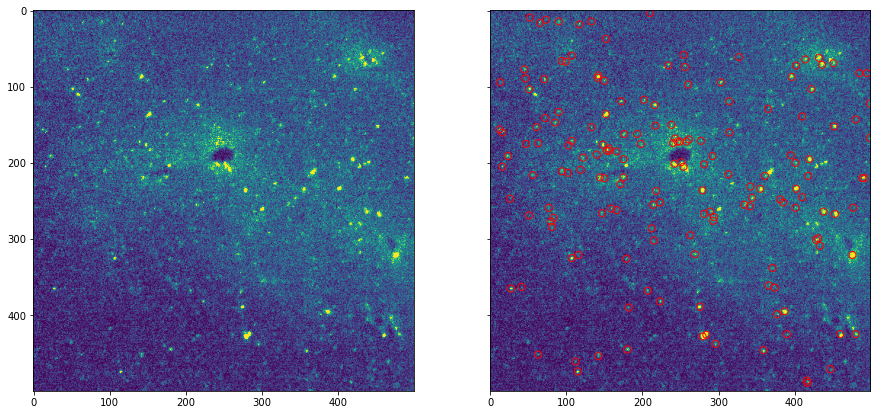

Z=5 plane


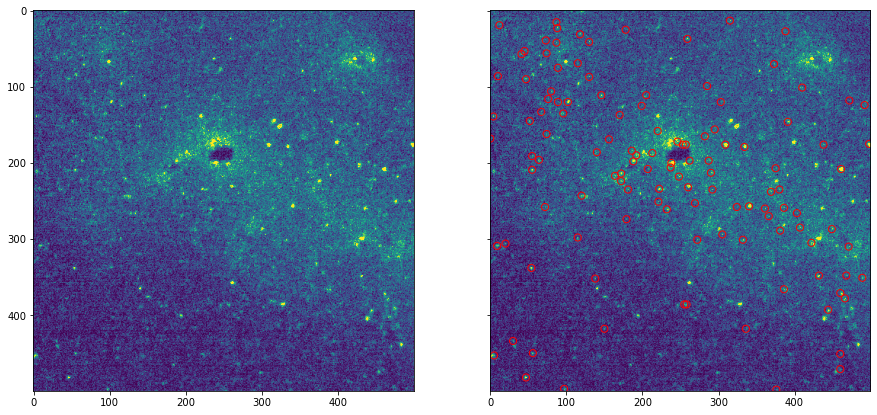

Z=10 plane


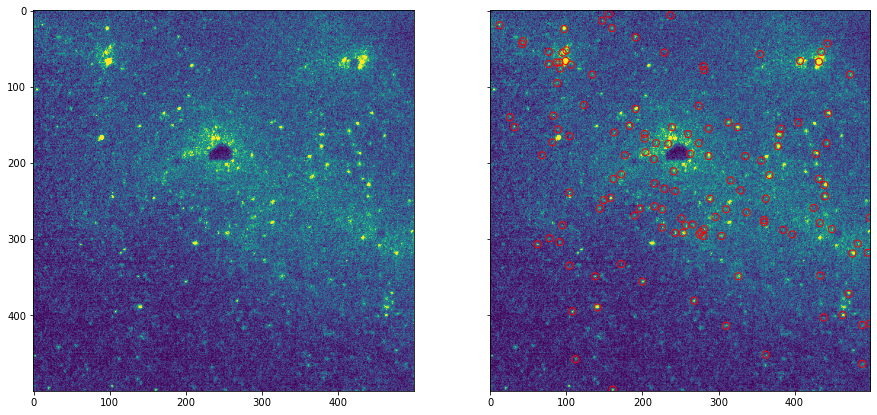

Z=15 plane


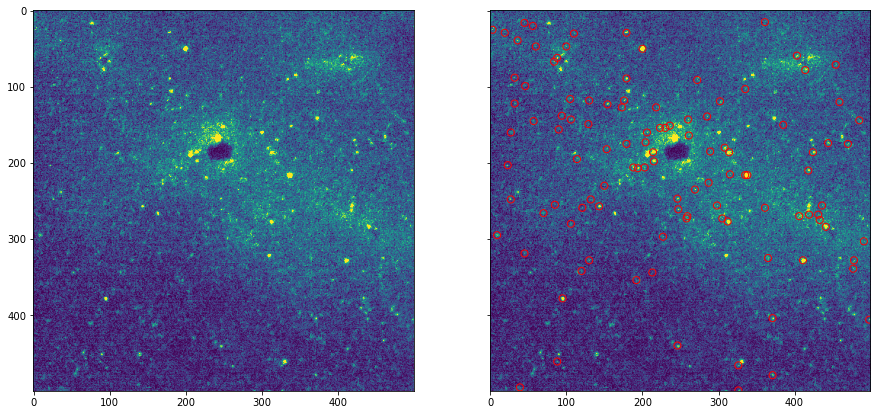

Z=20 plane


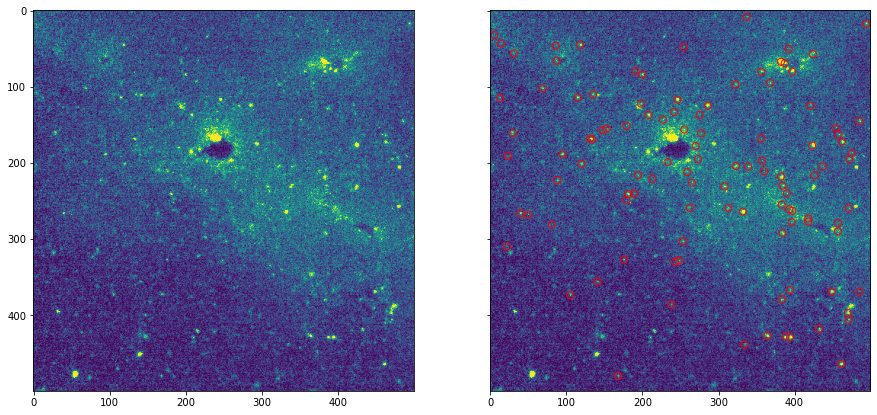

Z=25 plane


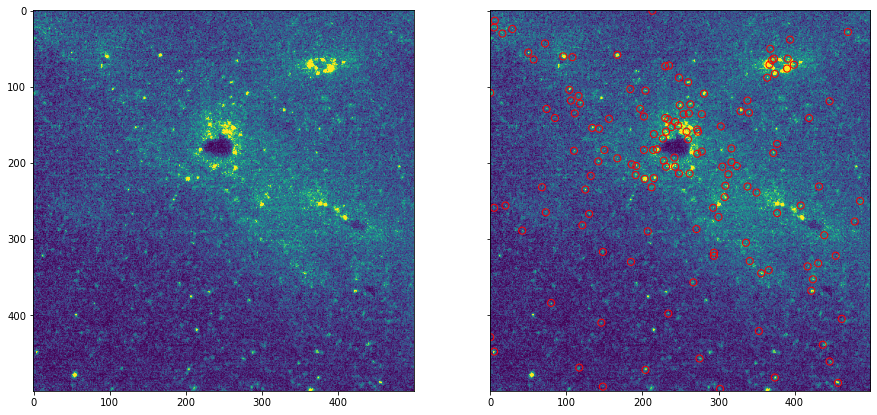

In [7]:
source = ws.source('cells', postfix='raw')
coordinates = np.hstack([source[c][:,None] for c in 'xyz']);
for z in range(0,30,5):
    print(f"Z={z} plane")
    stitched_z_plane = ws.source('stitched')[:,:,z]
    
    this_plane_coords = np.array([coord for coord in coordinates if coord[-1] == z])
    xs = this_plane_coords[:,0]
    ys = this_plane_coords[:,1]
    fig,axes = plt.subplots(figsize=(15,8),nrows=1,ncols=2,sharex=True,sharey=True)
    ax_tissue = axes[0]
    ax_tissue.imshow(stitched_z_plane,vmin=0,vmax=200,cmap='viridis')
    ax_both=axes[1]
    ax_both.imshow(stitched_z_plane,vmin=0,vmax=200,cmap='viridis')
    ax_both.scatter(ys,xs,s=50,facecolors='none',edgecolors='r')
    plt.show()

# Background shape size: 5, shape threshold size: 150 
Detected 7961 total cells


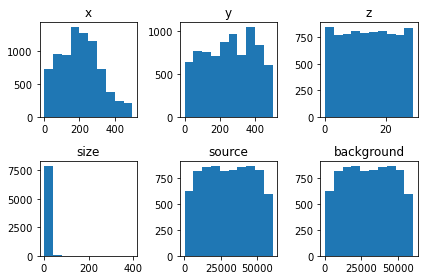

# Background shape size: 5, shape threshold size: 250 
Detected 487 total cells


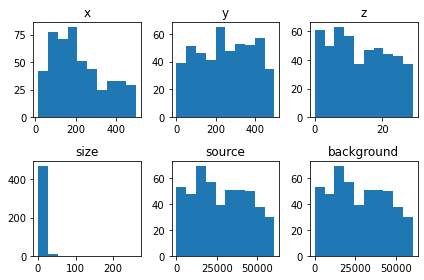

# Background shape size: 5, shape threshold size: 350 
Detected 148 total cells


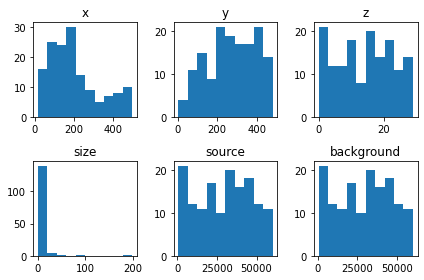

# Background shape size: 7, shape threshold size: 150 
Detected 10823 total cells


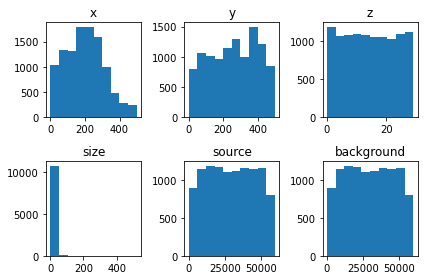

# Background shape size: 7, shape threshold size: 250 
Detected 611 total cells


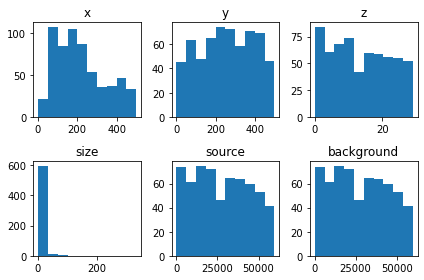

# Background shape size: 7, shape threshold size: 350 
Detected 202 total cells


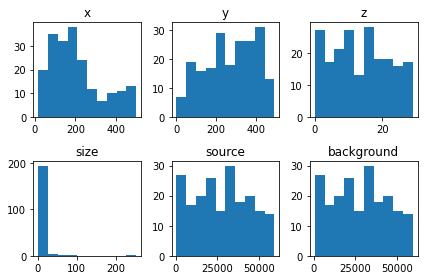

# Background shape size: 9, shape threshold size: 150 
Detected 12889 total cells


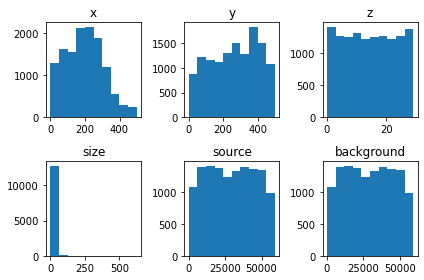

# Background shape size: 9, shape threshold size: 250 
Detected 696 total cells


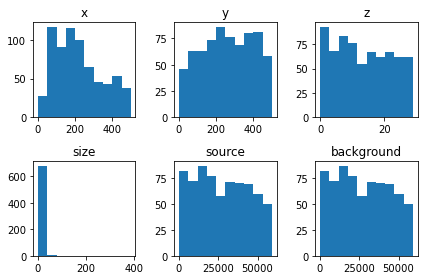

# Background shape size: 9, shape threshold size: 350 
Detected 226 total cells


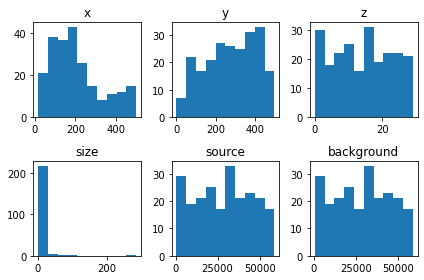

In [114]:
for background_size,shape_threshold_size in product(background_sizes,shape_threshold_sizes):
    postfix = f'raw_bck{background_size}_shpthresh{shape_threshold_size}'
    source = ws.source('cells', postfix=postfix)

    plt.figure(1); plt.clf();
    names = source.dtype.names;
    nx,ny = 2,3
    for i, name in enumerate(names):
        plt.subplot(nx, ny, i+1)
        plt.hist(source[name]);
        plt.title(name)
    plt.tight_layout();
    print(f"# Background shape size: {background_size}, shape threshold size: {shape_threshold_size} ")
    n_tot = len(source['x'])
    print(f"Detected {n_tot} total cells")
    plt.show()

